# Faster calculation of the lensing matrix

The current implementation in `Lensing.lensing_operator.LensingOperator` to compute the lensing matrix given a lens mass model generated by `lenstronomy` is slow. The reason is twofold : (1) the lensing matrix is built up in a pixel-by-pixel fashion, and (2) directly re-casting the resulting matrix as a (sparse) csr_matrix is not optimal.

This notebook explores a new method to accelerate this computation by (1) vectorisation along with fast numpy binning functions in order to compute all pixel values simultaneously, (2) initialising the csr_matrix differently by passing only the non-zero indices and their values as arguments, and separately (3) generating a tensorflow SparseTensor version of the lensing matrix for future speed comparisons of matrix operations.

The new approach is faster by factors of many hundreds to thousands, depending on the super-resolution level of the source plane. Subdividing the source plane grid by a factor of 2, 3, 4... is now essentially just as fast as for not super-resolving.

In [1]:
__author__ = 'austinpeel'
import time
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print("tensorflow", tf.__version__)

import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar

tensorflow 2.1.0


## Generate sample data

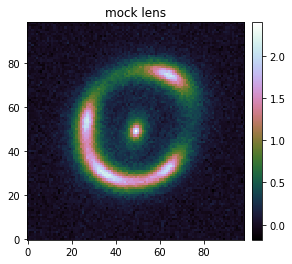

In [2]:
# =========

# type of lensing operator
lensing_operator = 'interpol'  # 'interpol' or 'simple'

# number of times to subdivide source plane grid
subgrid_res_source = 2

# starlets scales
n_scales_source = 6
n_scales_lens_light = 6

# compute and reduce source plane to minimal size
minimal_source_plane = False

# use the image mask computed through noise threshold
use_threshold_mask = False

# =========

# Data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF details
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
psf_num_pix_hd = int(np.ceil(psf_num_pix * subgrid_res_source) // 2 * 2 + 1)  # Round up to nearest odd number
psf_kernel_hd = kernel_util.kernel_gaussian(psf_num_pix_hd, delta_pix / subgrid_res_source, psf_fwhm)

kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)
kwargs_psf_hd = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel_hd}
psf_class_hd = PSF(**kwargs_psf_hd)

# List of lens mass model profiles
lens_model_list = ['SIE'] # ['SPEMD'] not using, since fast4ell is not installed
kwargs_spemd = {'theta_E': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 80, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                  'center_x': 0.1, 'center_y': 0.2}]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [{'amp': 10, 'R_sersic': 2, 'n_sersic': 3, 'e1': -0.2, 'e2': 0.1,
                      'center_x': 0, 'center_y': 0}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("mock lens")
im = plt.imshow(image_sim, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': n_scales_source, 
                          'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

lens_light_model_list_sparsefit = ['STARLETS']
kwargs_starlets_lens_light = {'n_scales': n_scales_lens_light, 
                              'n_pixels': np.size(image_sim)}  # add center_x/center_y
kwargs_lens_light_sparsefit = [kwargs_starlets_lens_light]
lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': -0.12,
    'delta_y_source_grid': 0.06
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,  # 'simple' or 'interpol'
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': minimal_source_plane,
    'min_num_pix_source': 69,
    
    'formulation': 'analysis',
    'initial_guess_type': 'noise_map',  # or 'background_rms' for just initializing with gaussian noise
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    #'num_iter': 100,  # when only source
    'num_iter_source': 100,
    'num_iter_lens': 100,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)

## Extract image and source planes

In [3]:
solver = imageSparseFit.sparseSolver
sourcePlane = solver.lensingOperator.sourcePlane
imagePlane = solver.lensingOperator.imagePlane

grid_offset_x = kwargs_special_sparsefit.get('delta_x_source_grid', 0)
grid_offset_y = kwargs_special_sparsefit.get('delta_y_source_grid', 0)
print(grid_offset_x, grid_offset_y)

-0.12 0.06


## Visualise image-to-source plane mapping

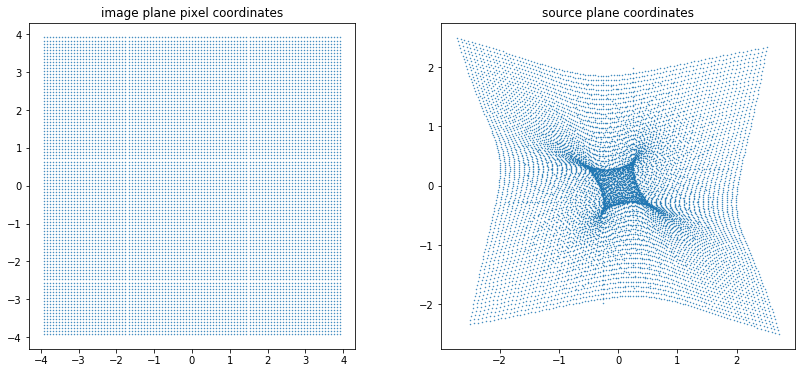

In [4]:
beta_x, beta_y = lens_model_class.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(imagePlane.theta_x, imagePlane.theta_y, s=0.2)
ax1.set_title("image plane pixel coordinates")
ax2.scatter(beta_x, beta_y, s=0.2)
ax2.set_title("source plane coordinates")
for ax in (ax1, ax2):
    ax.set_aspect('equal')

## Benchmark speed test

In [5]:
# Update the lensing operator manually
start = time.time()
solver.lensingOperator.update_mapping(kwargs_lens, kwargs_special_sparsefit)
end = time.time()
print("Building the lensing operator took {:e} s".format(end - start))

Building the lensing operator took 5.695757e+00 s


## New approach

In [6]:
def find_source_pixels(sourcePlane, beta_x, beta_y, grid_offset_x, grid_offset_y):
    # Standardize inputs for vectorization
    beta_x = np.atleast_1d(beta_x)
    beta_y = np.atleast_1d(beta_y)
    
    # Shift source grid if necessary
    source_theta_x = sourcePlane.theta_x + grid_offset_x
    source_theta_y = sourcePlane.theta_y + grid_offset_y
    
    # Compute bin edges so that (theta_x, theta_y) lie at the centers
    half_pix = sourcePlane.delta_pix / 2
    
    theta_x = source_theta_x[:sourcePlane.num_pix]
    xbins = np.linspace(theta_x[0] - half_pix, theta_x[-1] + half_pix, sourcePlane.num_pix + 1)
    index_x = np.digitize(beta_x, xbins) - 1

    theta_y = source_theta_y[::sourcePlane.num_pix]
    ybins = np.linspace(theta_y[0] - half_pix, theta_y[-1] + half_pix, sourcePlane.num_pix + 1)
    index_y = np.digitize(beta_y, ybins) - 1
    
    # Find the (1D) source plane pixel that (beta_x, beta_y) falls in
    index_1 = index_x + index_y * sourcePlane.num_pix
    
    # Compute distances between ray-traced betas and source grid points
    dx = beta_x - source_theta_x[index_1]
    dy = beta_y - source_theta_y[index_1]
    
    # Find the three other nearest pixels
    index_2 = index_1 + np.sign(dx).astype(int)
    index_3 = index_1 + np.sign(dy).astype(int) * sourcePlane.num_pix
    index_4 = index_2 + np.sign(dy).astype(int) * sourcePlane.num_pix
    
    # Gather indices (sorted for correct SparseTensor ordering)
    indices = np.sort([index_1, index_2, index_3, index_4], axis=0).T.flat
    
    # Compute bilinear weights like in Treu & Koopmans (2004)
    dist_x = (np.repeat(beta_x, 4) - source_theta_x[indices]) / sourcePlane.delta_pix
    dist_y = (np.repeat(beta_y, 4) - source_theta_y[indices]) / sourcePlane.delta_pix
    weights = (1. - np.abs(dist_x)) * (1. - np.abs(dist_y))
    
    # Construct 2D indices for use in build_lensing_matrix
    indices = (np.repeat(np.arange(imagePlane.grid_size), 4), indices)

    return indices, weights


def build_lensing_matrix(lensModel, kwargs_lens, imagePlane, sourcePlane, grid_offset_x, grid_offset_y,
                         sparse_tensor=False):
    # Compute lens mapping from image to source coordinates
    beta_x, beta_y = lensModel.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
    
    # Determine source pixels and their appropriate weights
    indices, weights = find_source_pixels(sourcePlane, beta_x, beta_y, grid_offset_x, grid_offset_y)
    
    # Build lensing matrix either as a sparse tensor or csr matrix
    dense_shape = (imagePlane.grid_size, sourcePlane.grid_size)
    if sparse_tensor:
        lensing_matrix = tf.sparse.SparseTensor(indices=np.column_stack(indices), 
                                                values=weights, dense_shape=dense_shape)
    else:
        lensing_matrix = sparse.csr_matrix((weights, indices), shape=dense_shape)
        
    return lensing_matrix

## Verify the new method's output

In [7]:
lm_old = solver.lensingOperator._lens_mapping
print(type(lm_old))
print("shape", lm_old.A.shape, "\n")

lm_new_csr = build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, 
                                  grid_offset_x, grid_offset_y, sparse_tensor=False)
print(type(lm_new_csr))
print("shape", lm_new_csr.shape, "\n")

lm_new_tensor = build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, 
                                     grid_offset_x, grid_offset_y, sparse_tensor=True)
print(type(lm_new_tensor))
print("shape", lm_new_tensor.shape, "\n")

print("old = new (scipy sparse) ?", np.allclose(lm_old.A, lm_new_csr.A))
print("old = new (tensorflow sparse) ?", np.allclose(lm_old.A, tf.sparse.to_dense(lm_new_tensor)))

<class 'scipy.sparse.csr.csr_matrix'>
shape (9801, 39204) 

<class 'scipy.sparse.csr.csr_matrix'>
shape (9801, 39204) 

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
shape (9801, 39204) 

old = new (scipy sparse) ? True
old = new (tensorflow sparse) ? True


## Timing

In [8]:
print("Returning a scipy sparse matrix")
%timeit build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, \
                             grid_offset_x, grid_offset_y, sparse_tensor=False)

print("\nReturning a tensorflow sparse matrix")
%timeit build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, \
                             grid_offset_x, grid_offset_y, sparse_tensor=True)

Returning a scipy sparse matrix
3.13 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Returning a tensorflow sparse matrix
2.89 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Matrix-vector product example

In [9]:
# Generate a random source image
s = np.random.randn(198, 198)
s_tf = tf.random.normal(shape=(s.size, 1), dtype=lm_new_tensor.dtype)

print("scipy sparse")
%timeit lm_new_csr.dot(s.flatten())

print("\ntensorflow sparse")
%timeit tf.sparse.sparse_dense_matmul(lm_new_tensor, s_tf)

scipy sparse
49.5 µs ± 587 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

tensorflow sparse
98 µs ± 381 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
